In [9]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'analysis_v3')
sys.path.append(PARENT_DIR)

from analysis_util import stats

In [3]:
cutoffs = [0, 200, 400, 600, 730, 840, 950, 1070]

result_parts = []
for i in range(len(cutoffs) - 1):
    result_parts.append(pd.read_csv(os.path.join(CURR_DIR, f'results_{cutoffs[i]}_{cutoffs[i + 1]}.frame'), index_col=0))

results = pd.concat(result_parts)
results.to_csv(os.path.join(CURR_DIR, 'results.frame'))

In [128]:
X_train = results[['heat_flux', 'mass_flow_rate', 'elastic_mod_factor', 'tangent_mod_factor', 'yield_strength_factor']]
Y_train = results['linearized_stress']

gpr_lin_stress, scaler_lin_stress = stats.make_gpr(X_train, Y_train)
stats.score_gpr(X_train, Y_train, gpr_lin_stress, scaler_lin_stress)

RMSE Validation: [-3.74737153 -3.04098465 -4.25255279]
Mean RMSE = -3.6803029908304734


In [167]:
def predict(x1, x2, params_provider, _gpr, _scaler):
    params = params_provider(x1, x2)
    offset = params[-1]

    scaled = _scaler.transform([params[:-1]])
    stress_pred = _gpr.predict(scaled)[0] - offset
    # print(f"{params_provider(x1, x2)} => {stress_pred}")
    return stress_pred


def contour(params_provider, x1_name, x2_name, _gpr, _scaler, n=30):
    x1_min = results[x1_name].min()
    x1_max = results[x1_name].max()
    
    pts = []

    for x2 in np.linspace(results[x2_name].min(), results[x2_name].max(), n):
        curr_x1_min = x1_min

        while True:
            f_min = predict(curr_x1_min, x2, params_provider, _gpr, _scaler)
            for x1_trial in np.linspace(curr_x1_min, x1_max, n):
                f_val = predict(x1_trial, x2, params_provider, _gpr, _scaler)
                if f_min * f_val < 0:
                    curr_x1_max = x1_trial
                    break
            else:
                break
        
            x1 = bisect(predict, curr_x1_min, curr_x1_max, args=(x2, params_provider, _gpr, _scaler))
            pts.append((x1, x2))

            curr_x1_min = curr_x1_max
    
    return np.array(pts)


PARAM_DEFAULTS = [10e6, 200, 1.0, 0.2, 1.0, 400]
PARAM_NAMES = ['heat_flux', 'mass_flow_rate', 'elastic_mod_factor', 'tangent_mod_factor', 'yield_strength_factor', 'offset']

RANGES = {
    'heat_flux': [5e6, 7.5e6, 10e6, 12.5e6, 15e6, 17.5e6, 20e6],
    'mass_flow_rate': [100, 150, 200, 250, 300],
    'elastic_mod_factor': [0.8, 0.9, 1.0, 1.1, 1.2],
    'yield_strength_factor': [0.8, 0.9, 1.0, 1.1, 1.2],
    'tangent_mod_factor': [0.1, 0.2, 0.3, 0.4],
    'offset': [300, 400, 500, 600, 700]
}

def gen_param_provider(x_name, y_name, var_name, var_val, **kwargs):
    x_i = PARAM_NAMES.index(x_name)
    y_i = PARAM_NAMES.index(y_name)
    var_i = PARAM_NAMES.index(var_name)

    def param_provider(x, y):
        params = PARAM_DEFAULTS.copy()
        params[x_i] = x
        params[y_i] = y
        params[var_i] = var_val

        for key, val in kwargs.items():
            params[PARAM_NAMES.index(key)] = val

        return params

    return param_provider


def plot_contours(x_name, y_name, var_name, title, ax=None, var_range=None, linestyle='solid', color=None, legend=True, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    if var_range is None:
        var_range = RANGES[var_name]

    ax.set_title(title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

    for var in var_range:
        param_prov = gen_param_provider(x_name, y_name, var_name, var, **kwargs)
        contour_pts = contour(param_prov, x_name, y_name, gpr_lin_stress, scaler_lin_stress)

        if len(contour_pts) > 0:
            ax.plot(contour_pts[:, 0], contour_pts[:, 1], linestyle=linestyle, color=color, label=f"{var_name}={var:.2f}")
        else:
            print(f"Skipping {var}.")
    
    if legend:
        ax.legend()

In [133]:
TITLE_GENS = {
    'heat_flux': lambda x: f"Heat = {x:.3e}",
    'mass_flow_rate': lambda x: f"Mass Flow = {x:.0f}",
    'elastic_mod_factor': lambda x: f"Elastic = {(x * 100):.0f}%",
    'tangent_mod_factor': lambda x: f"Tangent = {(x * 100):.0f}%",
    'yield_strength_factor': lambda x: f"Yield = {(x * 100):.0f}%",
    'offset': lambda x: f"Stress Lim = {x:.0f} MPa",
}


def eval_title(x_name, y_name, var_name):
    title = ""
    for name in PARAM_NAMES:
        if name not in [x_name, y_name, var_name]:
            default_val = PARAM_DEFAULTS[PARAM_NAMES.index(name)]
            title += TITLE_GENS[name](default_val) + " | "

    title = title.removesuffix(" | ")
    return title


def plot_all(x_name, y_name):
    plt.figure(figsize=(12, 12))

    params = PARAM_NAMES.copy()
    params.remove(x_name)
    params.remove(y_name)

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plot_contours(x_name, y_name, params[i], eval_title(x_name, y_name, params[i]), ax=ax)

Skipping 700.


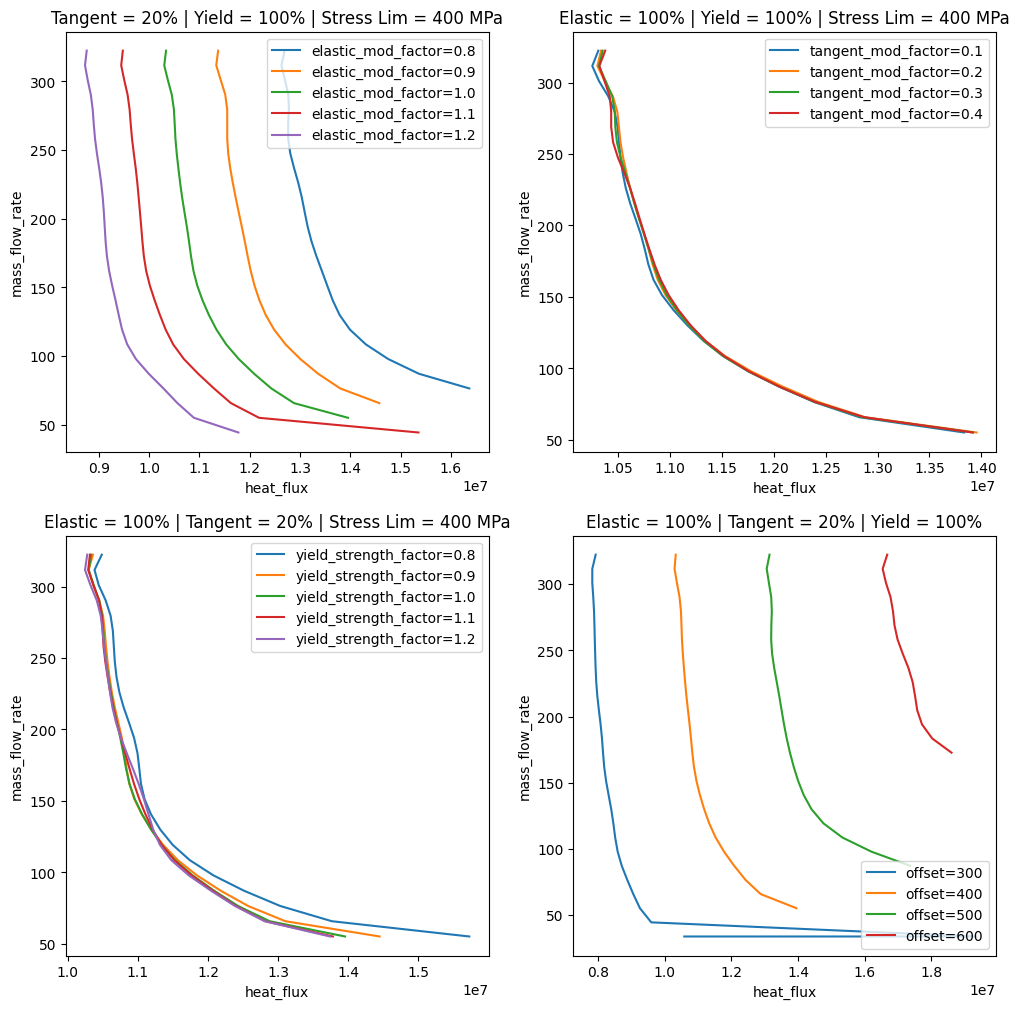

In [134]:
plot_all('heat_flux', 'mass_flow_rate')

Skipping 5000000.0.
Skipping 7500000.0.
Skipping 17500000.0.
Skipping 20000000.0.
Skipping 500.
Skipping 600.
Skipping 700.


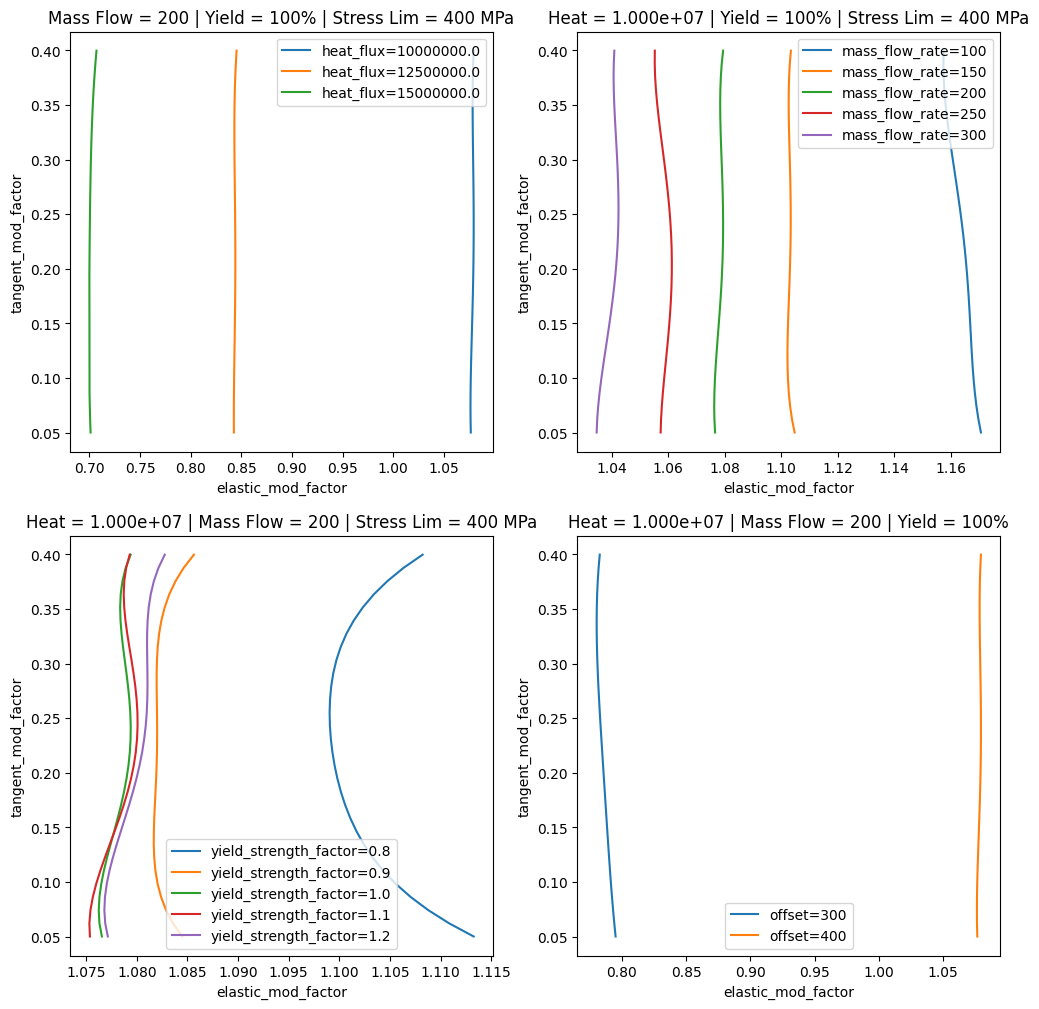

In [135]:
plot_all('elastic_mod_factor', 'tangent_mod_factor')

Skipping 5000000.0.
Skipping 7500000.0.
Skipping 17500000.0.
Skipping 20000000.0.
Skipping 500.
Skipping 600.
Skipping 700.


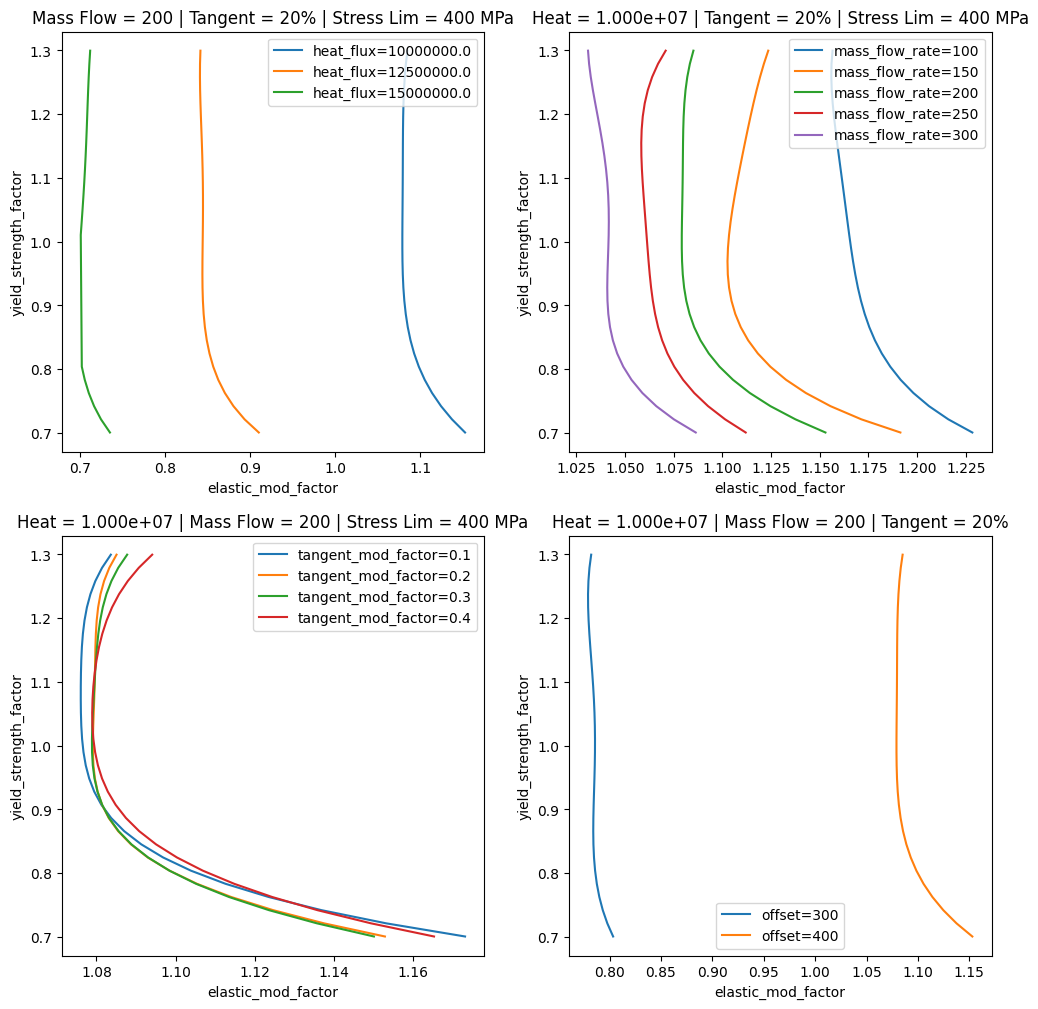

In [136]:
plot_all('elastic_mod_factor', 'yield_strength_factor')

Skipping 5000000.0.
Skipping 7500000.0.
Skipping 10000000.0.
Skipping 12500000.0.
Skipping 15000000.0.
Skipping 17500000.0.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping 20000000.0.
Skipping 100.
Skipping 150.
Skipping 200.
Skipping 250.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping 300.
Skipping 0.8.
Skipping 0.9.
Skipping 1.0.
Skipping 1.2.
Skipping 300.
Skipping 400.
Skipping 500.
Skipping 600.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Skipping 700.


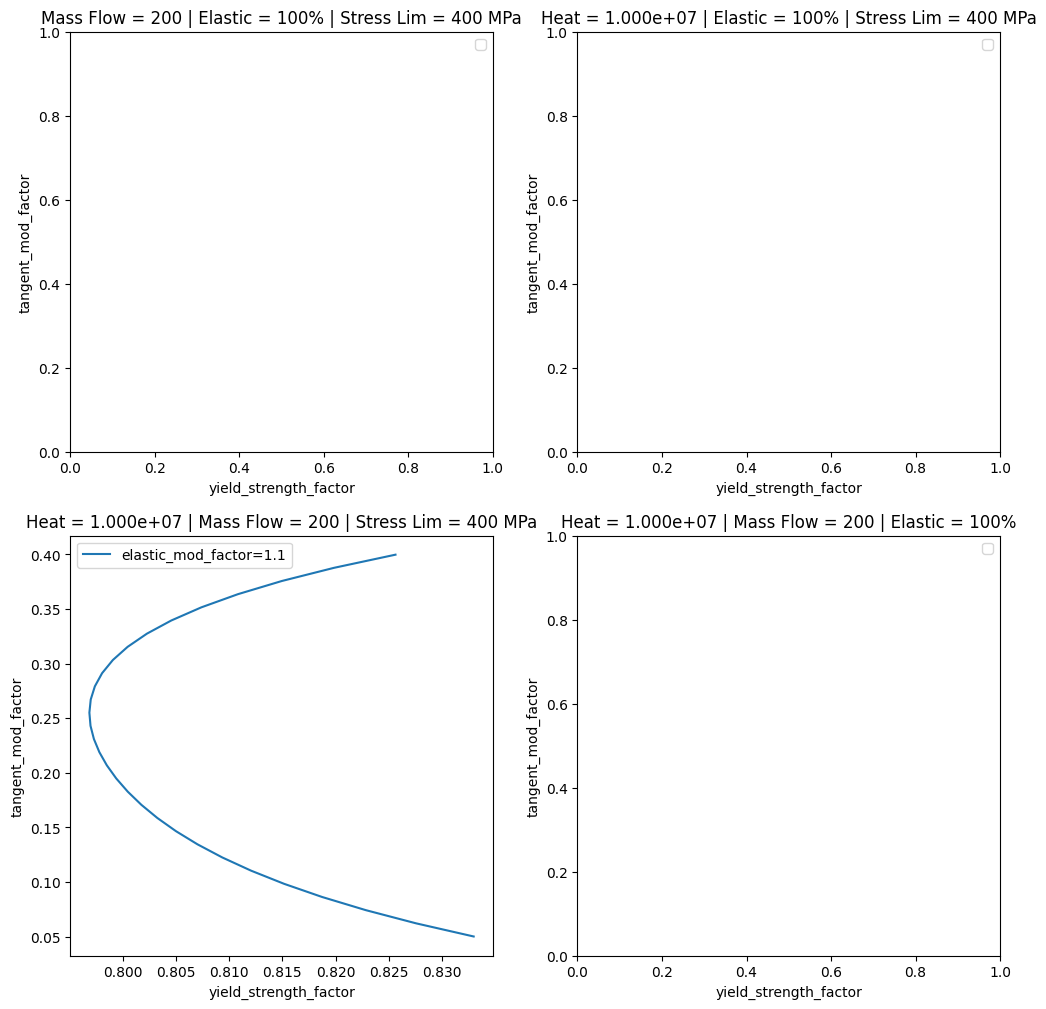

In [137]:
plot_all('yield_strength_factor', 'tangent_mod_factor')

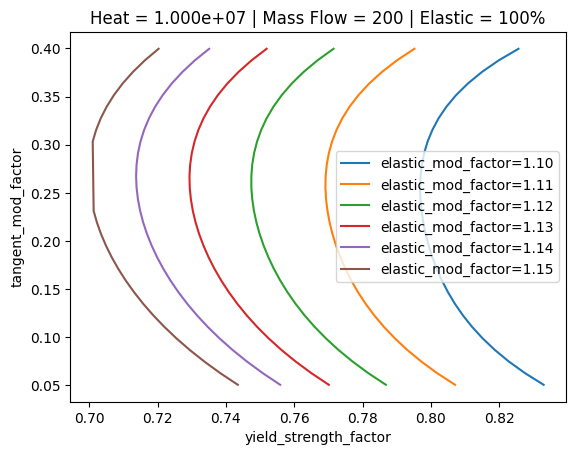

In [143]:
title = eval_title('yield_strength_factor', 'tangent_mod_factor', 'offset')
plot_contours('yield_strength_factor', 'tangent_mod_factor', 'elastic_mod_factor', title, var_range=np.arange(1.1, 1.16, 0.01))

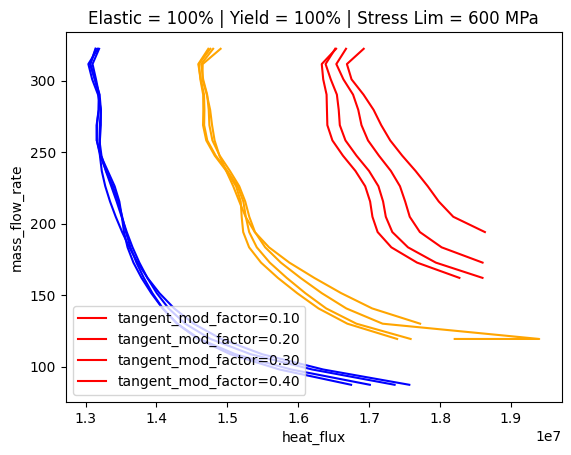

In [168]:
title = "Elastic = 100% | Yield = 100% | Stress Lim = 600 MPa"
fig, ax = plt.subplots()
plot_contours('heat_flux', 'mass_flow_rate', 'tangent_mod_factor', title, color='red', ax=ax, offset=600)
plot_contours('heat_flux', 'mass_flow_rate', 'tangent_mod_factor', title, color='orange', ax=ax, legend=False, offset=550)
plot_contours('heat_flux', 'mass_flow_rate', 'tangent_mod_factor', title, color='blue', ax=ax, legend=False, offset=500)

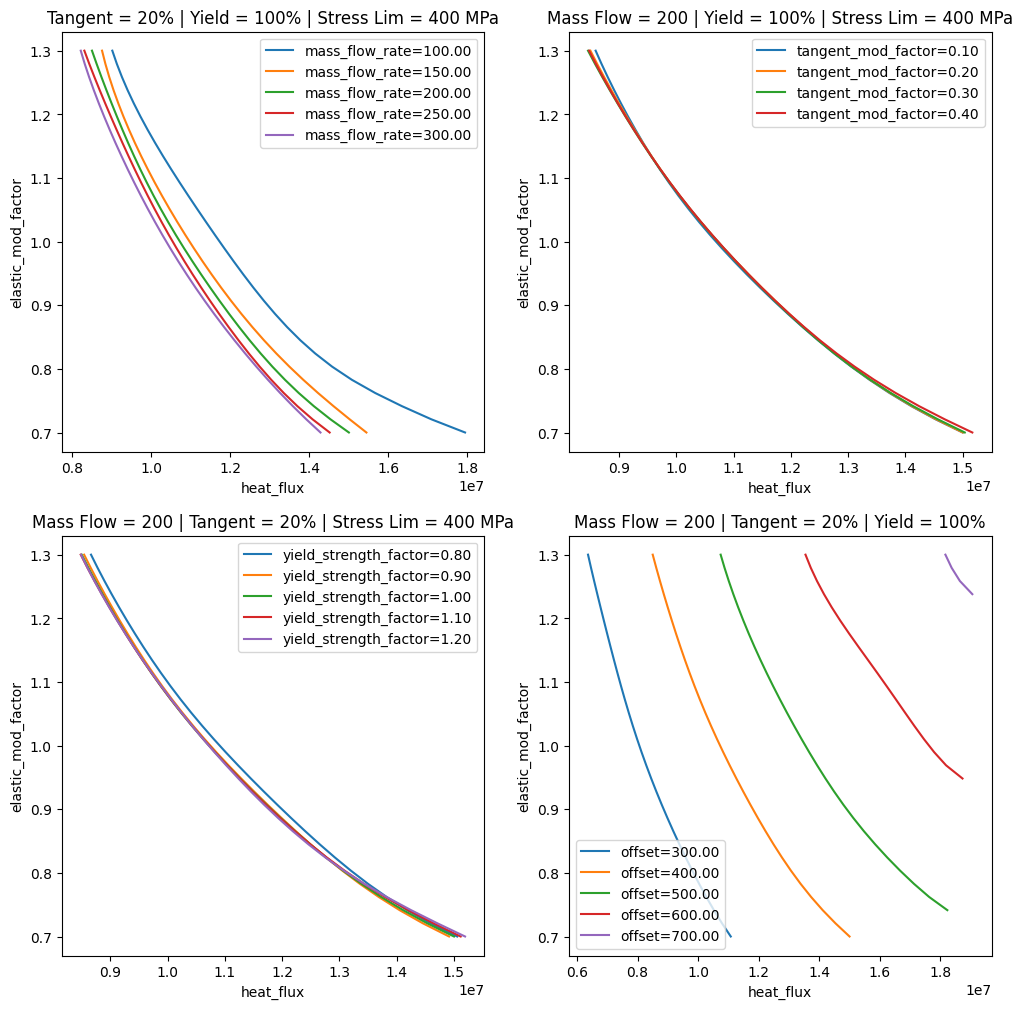

In [169]:
plot_all('heat_flux', 'elastic_mod_factor')

Skipping 700.


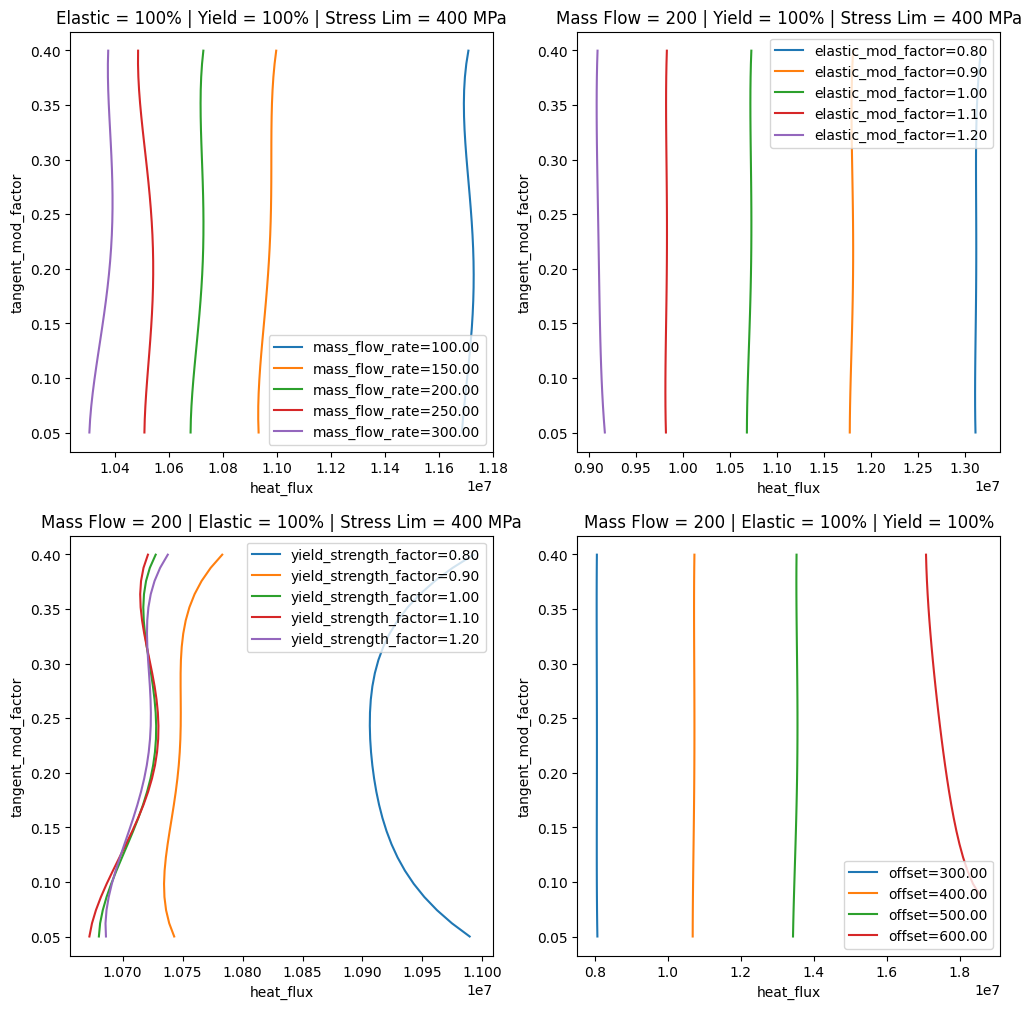

In [170]:
plot_all('heat_flux', 'tangent_mod_factor')

Skipping 700.


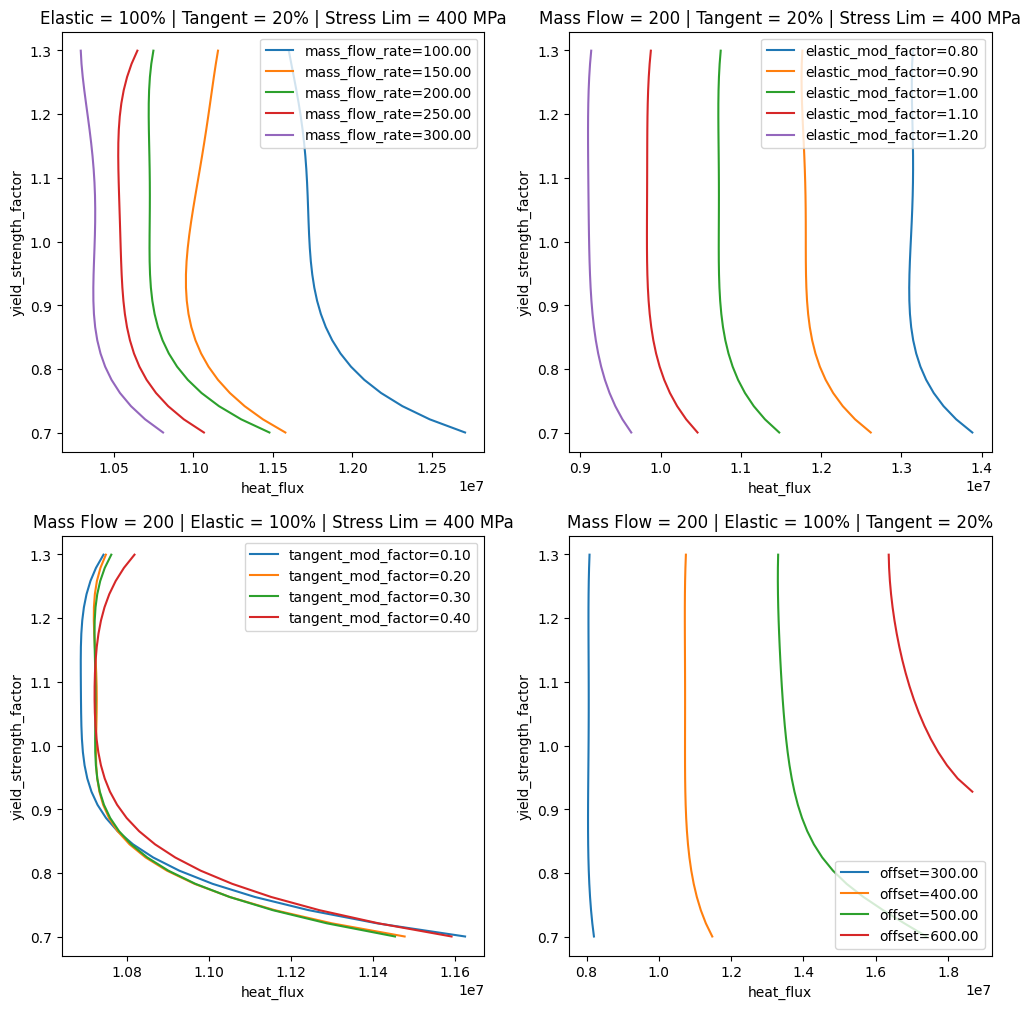

In [171]:
plot_all('heat_flux', 'yield_strength_factor')

Skipping 5000000.0.
Skipping 7500000.0.
Skipping 500.
Skipping 600.
Skipping 700.


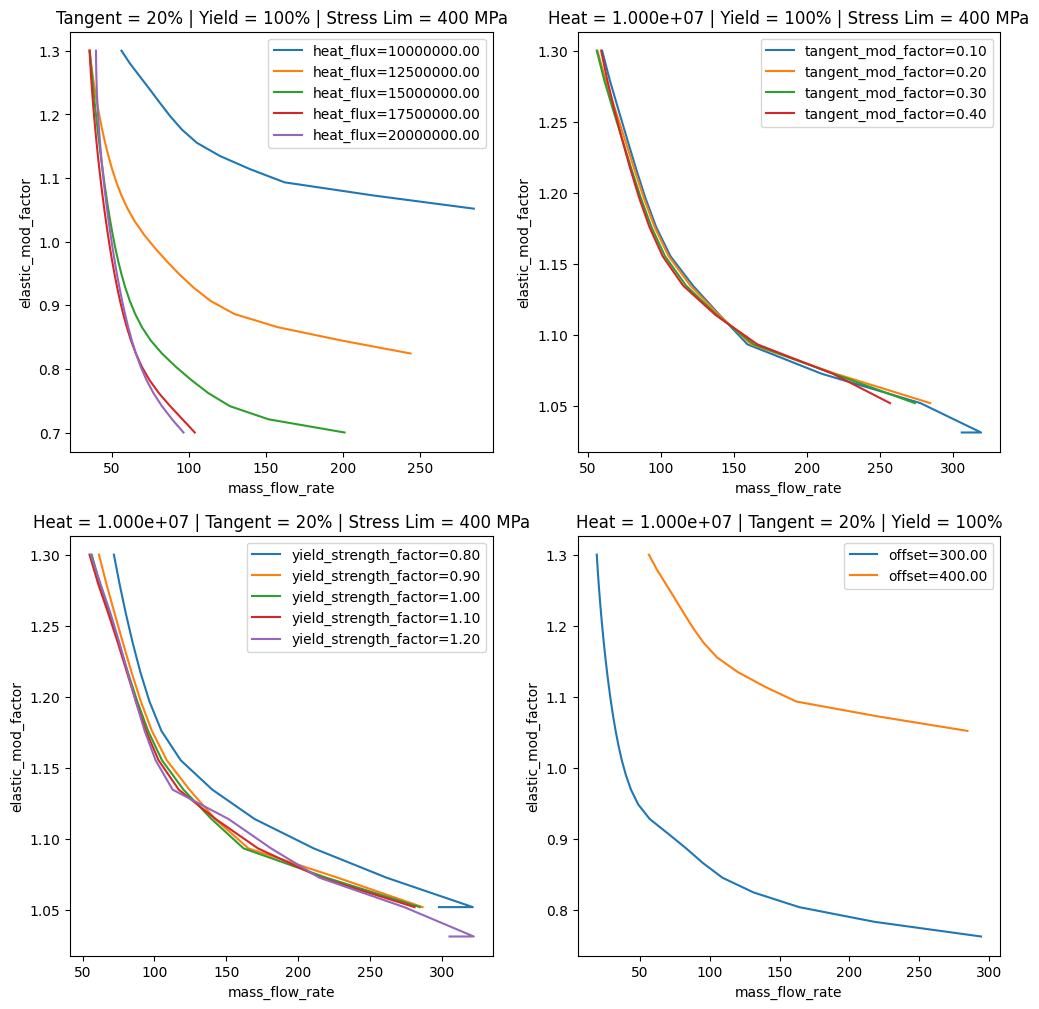

In [172]:
plot_all('mass_flow_rate', 'elastic_mod_factor')